In [9]:
%load_ext autoreload
%autoreload 2

import torch
import pyro
from pyro import distributions as dist
from pyro import poutine
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Simple model


$$x \sim \mathcal{N}(x|\mu, 1)$$

$$y \sim \mathcal{N}(y|x, 1)$$

#### Problem statement

Recover $p(y|\mu)$ with differentable neural network and be able to make gradient step of some statistic from 

$$r = R\left( \{ y_i \}_{i=0}^{B} \right)$$, 

i.e. be able to calculate:

$$\frac{\partial r}{\partial \mu} = ?$$.

## Make model with `pyro`

In [10]:
mu = torch.tensor(12., requires_grad=True)
mu = pyro.param('mu', mu)

In [11]:
x_dist = dist.Normal(mu, 1)

In [18]:
def f(x):
    return x.sin() + x.tanh()

#@pyro.condition(data={"x": torch.tensor(1.)})
def y_sample():
    x = pyro.sample("x", x_dist)
    x = f(x)
    return pyro.sample("y", dist.Normal(x, 1))

In [49]:
conditioned_y_sample = poutine.condition(y_sample, data={"x": torch.tensor(-1.)})

## Statistic of interest

$$r = \frac{1}{N} \sum\limits_{i=0}^{N} || y_i - Y ||_2^2$$

In [50]:
def r(ys: torch.tensor, Y_0=-5):
    return (ys - Y_0).pow(2).mean()

## Approaches to solve the problem

### First one

  1. Make approximation of this model:

  $$p(y | \mu)$$

  With GANs or some other techniques.
  

  2. Sample $\{ y_i \}_{i=0}^{B} \sim p(y | \mu)$
  
  
  3. Calc $r = R(\{ y_i \}_{i=0}^{B})$
  
  
  4. Find $\frac{\partial r}{\partial \mu}$
  
### Second one


  1. Make approximation of this model:

  $$p(r | \mu)$$
  
  
  2. Sample $r \sim p(r | \mu)$
  
  
  3. Find $\frac{\partial r}{\partial \mu}$

## Investigation of the model

In [51]:
samples = torch.stack([y_sample() for _ in range(1000)])

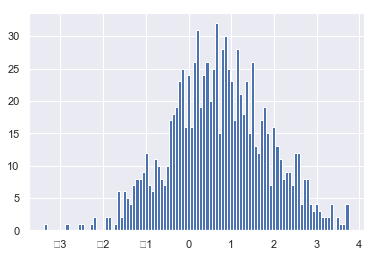

In [52]:
plt.hist(samples.detach().cpu().numpy(), bins=100);

In [53]:
r(samples).item()

34.02850341796875

In [54]:
samples = torch.stack([conditioned_y_sample() for _ in range(1000)])

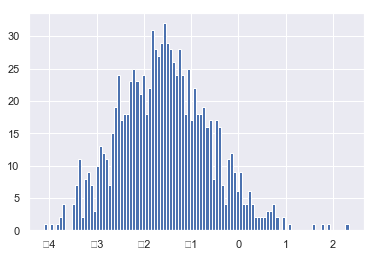

In [55]:
plt.hist(samples.detach().cpu().numpy(), bins=100);